<a href="https://colab.research.google.com/github/mehtamohit013/comms_lidar_ML/blob/main/BS_selection/multiple_seeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%%capture _
!unzip /gdrive/MyDrive/BTP/webots_data/final/data_split.zip
# !unzip /gdrive/MyDrive/BTP/Webots_data/val_data.zip
!pip install pytorch-lightning

# Imports

In [4]:
import pandas as pd 
import numpy as np
import os
import math
import scipy.io as io
from tqdm.notebook import tqdm

import torch 
from torch import nn
from torch.nn import functional as F

import pytorch_lightning as pl

import matplotlib.pyplot as plt
# %matplotlib qt

# Model Class

In [5]:
class incp(nn.Module):
    def __init__(self,drp:float=0.3,
                 drp_fc:float=0.2):
        super().__init__()
        
        self.drop_CNN = nn.Dropout(drp)
        self.drop_fc = nn.Dropout(drp_fc)
        self.mpool = nn.MaxPool2d((2,2))
        self.channels = 5
        self.fchannel = 3
        self.conv1 = self.create_conv(10,self.channels,13)
        self.conv2 = self.create_conv(self.channels,self.channels,13)
        self.conv3 = self.create_conv(self.channels,self.channels,7)
        self.conv4 = self.create_conv(self.channels,self.channels,7)

        # 1st Inception block
        self.in1 = nn.Sequential(
            self.create_conv(self.channels,self.fchannel,1),
            self.create_conv(self.fchannel,self.fchannel,3),
            self.create_conv(self.fchannel,self.fchannel,3)
        )
        self.in2 = nn.Sequential(
            self.create_conv(self.channels,self.fchannel,1),
            self.create_conv(self.fchannel,self.fchannel,3)
        )
        self.in3 = nn.Sequential(
            nn.MaxPool2d((3,3)),
            self.create_conv(self.channels,self.fchannel,1)
        )
        self.in4 = self.create_conv(self.channels,self.fchannel,1)

        # Second inception block
        self.in5 = nn.Sequential(
            self.create_conv(self.fchannel*4,self.fchannel,1),
            self.create_conv(self.fchannel,self.fchannel,3),
            self.create_conv(self.fchannel,self.fchannel,3)
        )
        self.in6 = nn.Sequential(
            self.create_conv(self.fchannel*4,self.fchannel,1),
            self.create_conv(self.fchannel,self.fchannel,3)
        )
        self.in7 = nn.Sequential(
            nn.MaxPool2d((3,3)),
            self.create_conv(self.fchannel*4,self.fchannel,1)
        )
        self.in8 = self.create_conv(self.fchannel*4,self.fchannel,1)

        self.conv5 = self.create_conv(self.fchannel*4,self.fchannel,7)
        self.conv6 = self.create_conv(self.fchannel,self.fchannel,7)

        self.conv7 = self.create_conv(self.fchannel,self.fchannel,3)
        self.conv8 = self.create_conv(self.fchannel,self.fchannel,3)
        
        self.flatten = nn.Flatten()

        # self.linear = nn.Sequential(
        #     nn.Linear(2352,256),
        #     nn.PReLU(1),
        #     nn.BatchNorm1d(256),
        #     self.drop_fc,
        #     nn.Linear(256,64),
        #     nn.PReLU(1),
        #     nn.BatchNorm1d(64),
        #     self.drop_fc,
        #     nn.Linear(64,16),
        #     nn.PReLU(1),
        #     nn.BatchNorm1d(16),
        #     self.drop_fc,
        #     nn.Linear(16,3)
        # )

        self.linear = nn.Sequential(
            nn.Linear(588,16),
            nn.PReLU(1),
            nn.BatchNorm1d(16),
            nn.Linear(16,3)
        )

    
    def forward(self,X):
        X  = self.conv1(X)
        X  = self.conv2(X)
        X = self.mpool(X)

        X = self.conv3(X)
        X = self.conv4(X)
        X = self.mpool(X)

        X = self.drop_CNN(X)

        a = self.in1(X)
        a = F.pad(a,[2,2,2,2])
        b = self.in2(X)
        b = F.pad(b,[1,1,1,1])
        c = self.in3(X)
        c = F.pad(c,[16,16,16,16])
        d = self.in4(X)

        X = torch.cat((a,b,c,d),1)

        X = self.drop_CNN(X)

        a = self.in5(X)
        a = F.pad(a,[2,2,2,2])
        b = self.in6(X)
        b = F.pad(b,[1,1,1,1])
        c = self.in7(X)
        c = F.pad(c,[16,16,16,16])
        d = self.in8(X)

        X = torch.cat((a,b,c,d),1)
        X = self.drop_CNN(X)

        X = self.conv5(X)
        X = self.conv6(X)

        X = self.mpool(X)

        X = self.drop_CNN(X)

        X = self.conv7(X)
        X = self.conv8(X)
        # print(X.shape)

        X = self.flatten(X)
        out = self.linear(X)

        return out
    
    def create_conv(self,in_layers:int,out_layers:int,kernel,stride:int=1,
                    padding:int=0) -> nn.Module :

        return nn.Sequential(
            nn.Conv2d(in_layers,out_layers,kernel,stride,padding),
            nn.PReLU(out_layers),
            nn.BatchNorm2d(out_layers)
        )

# Lightning Trainer


In [6]:
class lidar_trainer(pl.LightningModule):
    def __init__(self,use_model:str='incp',
                 drop_prob:float = 0.3,
                 drop_prob_fc:float = 0.2,
                 learning_rate:float = 1e-3,
                 weight_decay:float = 0.0):
        
        '''
        use_model = 'NU','imp'
        '''

        self.drp = drop_prob
        self.drp_fc = drop_prob_fc

        super().__init__()
        if use_model == 'NU':
            self.model = NU(drp=drop_prob,drp_fc = drop_prob_fc)
        elif use_model == 'imp':
            self.model = imp_lidar(drp=drop_prob,drp_fc = drop_prob_fc)
        elif use_model == 'm1':
            self.model = m1(drp=drop_prob,drp_fc = drop_prob_fc)
        elif use_model == 'incp':
            self.model = incp(drp=drop_prob,drp_fc = drop_prob_fc)

        self.celoss = nn.CrossEntropyLoss()
        self.lr = learning_rate
        self.wd = weight_decay

        self.train_acc = 0
        self.val_acc = 0
        self.test_acc = 0

        self.example_input_array = torch.rand(1,10,240,240) # For logging graph
    
    def forward(self,lidar):
        out = self.model(lidar)
        return out
    
    def training_step(self,batch,batch_idx):
        lidar = batch['lidar'].float()
        label = batch['label'].long()
        
        yhat = self(lidar)
        
        loss = self.celoss(yhat,label)
        
        self.log('Train Loss',loss)
        
        return {'loss':loss,'pred':yhat.cpu().detach(),'label':label.cpu().detach()}
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(),self.lr,
                               weight_decay=self.wd)
        return opt
    
    def training_epoch_end(self,train_out):        
        len_out = len(train_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = train_out[i]['pred'] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = train_out[i]['label']

        top1 = top_k_acc(y_true,y_pred,k=1)

        # Calculating Avg loss
        avg_loss = torch.stack([x['loss'] for x in train_out]).mean()
        
        self.logger.experiment.add_scalar('Loss-Train per epoch',avg_loss,self.current_epoch)
        self.logger.experiment.add_scalar('Train Accuracy',top1,self.current_epoch)

        self.train_acc = top1
        
        print(f'Train accuracies is {top1}')

    def validation_step(self,batch,batch_idx):
        lidar = batch['lidar'].float()
        label = batch['label'].long()
        
        yhat = self.forward(lidar)
        
        return [yhat.cpu().detach(),label.cpu().detach()]
     
    def validation_epoch_end(self,val_out):
        len_out = len(val_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = val_out[i][0] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = val_out[i][1] 

        top1 = top_k_acc(y_true,y_pred,k=1)
        self.val_acc = top1

        self.logger.experiment.add_scalar('Validation Accuracy',top1,self.current_epoch)

        print(f'Validation accuracy is {top1}')
    
    def test_step(self,batch,batch_idx):
        lidar = batch['lidar'].float()
        label = batch['label'].long()
        
        yhat = self.forward(lidar)
        
        return [yhat.cpu().detach(),label.cpu().detach()]
     
    def test_epoch_end(self,val_out):
        len_out = len(val_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = val_out[i][0] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = val_out[i][1] 

        top1 = top_k_acc(y_true,y_pred,k=1)
        self.test_acc = top1

        self.logger.experiment.add_hparams(
            {
                'LR' : self.lr,
                'weight_decay' : self.wd,
                'drop_prob' : self.drp,
                'drop_fc' : self.drp_fc,
                'overall params' : sum(p.numel() for p in self.model.parameters())
            },
            {
                'hparam/test_acc' : self.test_acc,
                'hparam/train_acc' : self.train_acc,
                'hparam/val_acc' : self.val_acc
            }
        )
        print(f'Test accuracy is {top1}')

# Loading Models

In [8]:
models = list()
num_model = 10
seed_dir = '/gdrive/MyDrive/BTP/seeds/seeds'

for i in range(0,num_model):
    tmp = seed_dir+f'/tb_logs_seed_{i}/inception/version_0/checkpoints'
    tmp += '/' + os.listdir(tmp)[0]
    
    tmp_trainer = lidar_trainer(use_model='incp',drop_prob=0.3,drop_prob_fc=0.2,weight_decay=1e-4,learning_rate=3.63e-4)
    tmp_model = tmp_trainer.load_from_checkpoint(tmp)
    
    models.append(tmp_model)

# Loading testing data

In [17]:
dpath = '.'
gps_pd = pd.read_pickle('/gdrive/MyDrive/BTP/seeds/seeds/gps_stats_new.pkl')
acc = list()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for i in range(0,num_model):
    models[i].model.to(device)

for i in tqdm(gps_pd.index.values):
    name = gps_pd.at[i,'Lidar']
    lidar_data = torch.tensor(np.load(dpath+f'/lidar_compressed/{name}')['lidar'].reshape(1,10,240,240).astype('float32'),device=device)   
    label = io.loadmat(dpath+f'/labels/{name[:-3]}mat')['ss']
    label = np.argmax(label.astype('float64'))
    
    tmp_acc = list()
    for j in range(0,num_model):
        tmp = models[j].model
        tmp.eval()
        pred = tmp(lidar_data)
        
        if(label == torch.argmax(pred)):
            tmp_acc.append(1)
        else:
            tmp_acc.append(0)
    
    acc.append(tmp_acc)

  0%|          | 0/14902 [00:00<?, ?it/s]

In [18]:
gps_pd['seed_acc'] = acc

In [19]:
gps_pd.to_pickle('/gdrive/MyDrive/BTP/seeds/seeds/gps_seed.pkl')

# Graphs

In [45]:
gps_pd = pd.read_pickle('/gdrive/MyDrive/BTP/seeds/seeds/gps_seed.pkl')

## Distribution Graph

<BarContainer object of 21 artists>

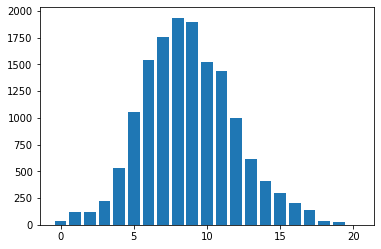

In [46]:
surr = [0]*21

for i in (gps_pd.index.values):
    surr[gps_pd.at[i,'veh_range']]+=1

plt.bar(range(0,21),surr)

## Accuracy Graph

In [47]:
gps_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14902 entries, 0 to 14901
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      14902 non-null  int64 
 1   Time       14902 non-null  object
 2   Name       14902 non-null  object
 3   Model      14902 non-null  object
 4   GPS        14902 non-null  object
 5   Speed      14902 non-null  object
 6   Lidar      14902 non-null  object
 7   BS         14902 non-null  object
 8   veh_range  14902 non-null  int64 
 9   veh_dist   14902 non-null  object
 10  Pred       14902 non-null  int64 
 11  seed_acc   14902 non-null  object
dtypes: int64(3), object(9)
memory usage: 1.4+ MB


In [48]:
acc = list()

for i in range(0,21):
    tmp = list()
    for j in range(0,num_model):
        true = 0
        ovr = 0
        for k in gps_pd.index.values:
            if gps_pd.at[k,'veh_range'] == i:
                if gps_pd.at[k,'seed_acc'][j] == 1:
                    true+=1
                ovr+=1
        
        tmp_acc = float(true)/float(ovr)
        tmp.append(tmp_acc)
    acc.append(tmp)
            

In [49]:
sum(acc[0])/len(acc[0])

0.6393939393939394

In [50]:
avg_acc = list()

for i in range(0,21):
    avg_acc.append((sum(acc[i])/(len(acc[i]))))
    

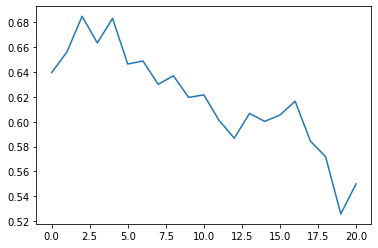

In [51]:
plt.plot(range(0,21),avg_acc)